In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import tabulate

import methods.pilot_estimation as pilot_estimation
import methods.interpolation as interpolation
import methods.equalizer as equalizer

importlib.reload(pilot_estimation)
importlib.reload(interpolation)
importlib.reload(equalizer)

global frame_length, prefix_length, data_length, fft_size, pilot_indices, data_indices, pilot_symbol, image_size, corr_coeff

datasets = [scipy.io.loadmat(f'DataSet/DataSet{i + 1}.mat') for i in range(3)]
ofdm = datasets[0]['OFDM']
channel = datasets[0]['Channel']
image_size = [int(i) for i in datasets[0]['ImageSize'][0]]

channel = { 'Name': str(channel[0][0][0][0]),
            'Length': int(channel[0][0][1][0][0]),
            'DopplerFreq': int(channel[0][0][2][0][0]),
            'CorrCoefficient': float(channel[0][0][3][0][0])}

ofdm = {'Name': str(ofdm[0][0][0][0]),
        'Bandwidth': int(ofdm[0][0][0][0].split('Mz')[0]) * 10**6,
        'SamplingFrq': int(ofdm[0][0][1][0][0]),
        'CarrierFreq': int(ofdm[0][0][2][0][0]),
        'FFTSize': int(ofdm[0][0][3][0][0]),
        'DataSubcarriers': int(ofdm[0][0][4][0][0]),
        'Modulation': str(ofdm[0][0][5][0]),
        'PilotIndices': ofdm[0][0][6][0],
        'DataIndices': ofdm[0][0][7][0],
        'FrameLen': int(ofdm[0][0][8][0][0]),
        'PilotSymbols': ofdm[0][0][9][0]}

pilot_indices = ofdm['PilotIndices'] - 1  # Convert to zero-based indexing
data_indices = ofdm['DataIndices'] - 1    # Convert to zero-based indexing

channel_length = channel['Length']
prefix_length = channel_length - 1
fft_size = ofdm['FFTSize']
frame_length = ofdm['FrameLen']

num_pilots = len(pilot_indices)
pilot_symbol = ofdm['PilotSymbols'][0]

corr_coeff = channel['CorrCoefficient']

In [2]:
def decode(signal: np.array, pilot_estimation_method: callable, interpolation_method: callable, equalizing_method: callable, **kwargs) -> np.array:
    '''
    Decode the received signal using variable methods for pilot estimation, channel interpolation, and equalization.
    
    :param np.array signal: Received OFDM signal
    :param function pilot_estimation_method: Method for pilot estimation
    :param function interpolation_method: Method for channel interpolation
    :param function equalizing_method: Method for equalization
    :param dict kwargs: Additional arguments passed on to the various methods
    :return np.array: Estimated QPSK symbols    
    '''
    
    # Removing the cyclic prefix and splitting the signal into the OFDM symbols
    signals = [signal[i * fft_size + (i + 1) * prefix_length : (i + 1) * (fft_size + prefix_length)] for i in range(frame_length)]
    
    # Calculate the FFT for each OFDM symbol
    ffts = np.array([np.fft.fft(s) / np.sqrt(fft_size) for s in signals])
    
    # Estimate the noise variance by using zero subcarriers from the zero padding of the FFTs
    zero_subcarriers = np.setdiff1d(np.arange(fft_size), np.concatenate([data_indices, pilot_indices]))
    zero_samples = np.concatenate([ffts[i][zero_subcarriers] for i in range(frame_length)])
    noise_variance = np.mean(np.abs(zero_samples)**2)
    
    # Estimate the process variance for the Kalman filter if not provided (WIP, no idea if this actually works)
    all_pilot_estimations_naive = pilot_estimation.naive(ffts, pilot_indices, pilot_symbol).flatten()
    tap_variance_estimate = fft_size * (np.mean(np.abs(all_pilot_estimations_naive) ** 2) - noise_variance) / channel_length
    
    # Estimate the channel for all pilot subcarriers using the provided pilot estimation method
    pilot_kwargs = {'corr_coeff': corr_coeff, 'tap_variance': tap_variance_estimate, 'noise_variance': noise_variance}
    pilot_estimations = pilot_estimation_method(ffts, pilot_indices, pilot_symbol, **pilot_kwargs)
    
    # Interpolate the channel for all subcarriers using the provided interpolation method considering the pilot estimations
    gamma = tap_variance_estimate
    interpolation_kwargs = {'noise_variance': noise_variance, 'gamma': gamma, 'channel_length': channel_length}
    interpolation_kwargs.update(kwargs)
    channel_estimations = [interpolation_method(fft_size, pilot_indices, pilot_estimations[i], **interpolation_kwargs) for i in range(frame_length)]
    
    # Use the channel estimations and the provided equalizer to estimate the QPSK symbols for all data subcarriers
    qpsk_estimations = [equalizing_method(ffts[i], channel_estimations[i], noise_variance)[data_indices] for i in range(frame_length)]    

    # Combine all estimated QPSK symbols into a single array and return
    return np.concatenate(qpsk_estimations)

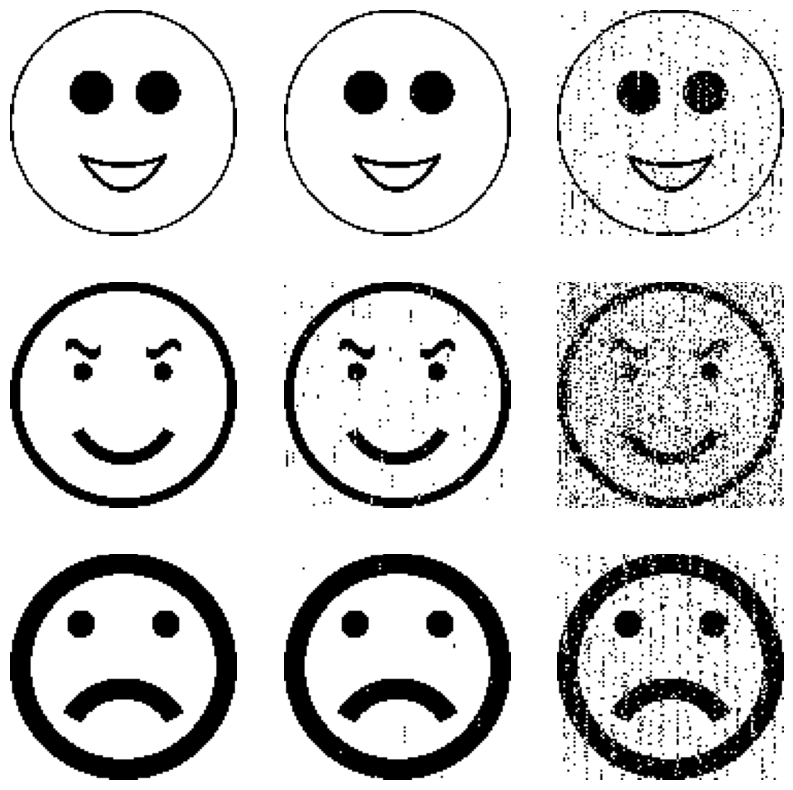

In [3]:
images = []
for d in range(3):
    for n in ['NoNoise_RxSignal', 'LowNoise_RxSignal', 'HighNoise_RxSignal']:
        image_bits = []
        signal = datasets[d][n].flatten()
        qpsk_estimations = decode(signal, pilot_estimation.kalman_filter, interpolation.wiener, equalizer.mmse, **{'process_variance_estimate': 0.01, 'constant': 1.2})
        for symbol in qpsk_estimations:
            image_bits.append((1 - int(np.sign(symbol.imag))) // 2)
            image_bits.append((1 - int(np.sign(symbol.real))) // 2)

        image = (np.array(image_bits[:image_size[0] * image_size[1]]).reshape((image_size[1], image_size[0])) * 255).astype(np.uint8)
        images.append(image.T)

# Show all 9 images in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[i * 3 + j], cmap='gray', vmin=0, vmax=255)
        axs[i, j].axis('off')

In [4]:
def calculate_mse(qpsk_estimations: np.array, true_symbols: np.array) -> float:
    ''' 
    Calculate Mean Squared Error between estimated and true symbols

    :param np.array qpsk_estimations: Estimated QPSK symbols
    :param np.array true_symbols: True QPSK symbols

    :return float: Mean Squared Error
    '''
    
    errors = qpsk_estimations - true_symbols
    return np.mean(np.abs(errors)**2)

In [5]:
def calculate_ber(qpsk_estimations: np.array, true_symbols: np.array) -> float:
    '''
    Calculate Bit Error Rate between demodulated estimated and true symbols

    :param np.array qpsk_estimations: Estimated QPSK symbols
    :param np.array true_symbols: True QPSK symbols

    :return float: Bit Error Rate
    '''

    # Demodulate estimated QPSK symbols to bits
    estimated_bits = np.array([(1 if s.real > 0 else 0, 1 if s.imag > 0 else 0) for s in qpsk_estimations]).flatten()
    
    # Demodulate true QPSK symbols to bits
    true_bits = np.array([(1 if s.real > 0 else 0, 1 if s.imag > 0 else 0) for s in true_symbols]).flatten()

    # Calculate Bit Error Rate
    bit_error_rate = np.sum(estimated_bits != true_bits) / len(true_bits)
    return bit_error_rate

In [6]:
# Define all possible methods for each step in decoding
pilot_methods = [pilot_estimation.naive, pilot_estimation.kalman_filter]
interp_methods = [interpolation.linear, interpolation.wiener, interpolation.spline]
equalizer_methods = [equalizer.zero_forcing, equalizer.mmse]

# Assign names to the methods for display in the table
pilots = ['Naive', 'Kalman']
interpolations = ['\u00A0Linear\u00A0', 'Wiener', '\u00A0Spline\u00A0']
equalizers = ['\u2003ZF\u2007\u00A0', 'MMSE']

# Define noise levels corresponding to the datasets
noise_levels = ['NoNoise_RxSignal', 'LowNoise_RxSignal', 'HighNoise_RxSignal']

datasets_inds = [0, 1, 2]

method_names = []
results = []

# Iterate over all combinations of methods, noise levels and datasets to evaluate performance
for p_idx, p_method in enumerate(pilot_methods):
    for i_idx, i_method in enumerate(interp_methods):
        for e_idx, e_method in enumerate(equalizer_methods):
            row = []
            method_names.append(f'{pilots[p_idx]} | {interpolations[i_idx]} | {equalizers[e_idx]}')
            for n in noise_levels:
                for d in datasets_inds:
                    signal = datasets[d][n].flatten()
                    qpsk_estimations = decode(signal, p_method, i_method, e_method, **{'process_variance_estimate': 0.01, 'constant': 1.2})
                    true_symbols = np.loadtxt(f'recovered_signals/recovered_signal_dataset{d+1}.txt', dtype=np.complex128)
                    mse = calculate_mse(qpsk_estimations[:image_size[0] * image_size[1] // 2], true_symbols)
                    ber = calculate_ber(qpsk_estimations[:image_size[0] * image_size[1] // 2], true_symbols)
                    
                    row.append((mse, ber))
            results.append(row)

In [7]:
columns = []
for n in noise_levels:
    for d in datasets_inds:
        columns.append(f'D{d + 1}-{n[:-9]}')

mse_df = pd.DataFrame([[x[0] for x in row] for row in results], columns=columns, index=method_names)
ber_df = pd.DataFrame([[x[1] for x in row] for row in results], columns=columns, index=method_names)
be_df = pd.DataFrame([[int(x[1]*(image_size[0] * image_size[1])) for x in row] for row in results], columns=columns, index=method_names)

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: darkgreen' if v else '' for v in is_min]

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

def do_none(s):
    return ['' for _ in s]

mse_df.columns.name = 'Mean Squared Error (MSE)'
ber_df.columns.name = 'Bit Error Rate (BER)'
be_df.columns.name = 'Bit Errors (BE)'

styled_df = be_df.style.apply(highlight_max, axis=0).apply(highlight_min, axis=0)

# styled_df.to_latex('mse_table.tex', position='H', hrules=True, caption='Mean Squared Error (MSE) for Different Method Combinations Across Datasets and Noise Levels', label='tab:mse_table')

styled_df

Bit Errors (BE),D1-NoNoise,D2-NoNoise,D3-NoNoise,D1-LowNoise,D2-LowNoise,D3-LowNoise,D1-HighNoise,D2-HighNoise,D3-HighNoise
Naive | Linear | ZF,0,35,1,7,217,43,682,2740,1163
Naive | Linear | MMSE,0,35,1,7,217,43,682,2740,1163
Naive | Wiener | ZF,0,0,0,3,199,26,639,2496,1046
Naive | Wiener | MMSE,0,0,0,3,199,26,639,2496,1046
Naive | Spline | ZF,0,0,0,7,235,42,813,2901,1263
Naive | Spline | MMSE,0,0,0,7,235,42,813,2901,1263
Kalman | Linear | ZF,0,35,1,6,163,41,520,2314,918
Kalman | Linear | MMSE,0,35,1,6,163,41,520,2314,918
Kalman | Wiener | ZF,0,0,0,3,152,17,491,2163,849
Kalman | Wiener | MMSE,0,0,0,3,152,17,491,2163,849
